# HH, HG, TG, HMC on D-dimensional Gaussian - ESS

In [112]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from utils import logp as logp_scale
from Zappa.zappa import zappa_sampling_multivariate, zappa_sampling
from Zappa.ZappaStore import Zappa
from Manifolds.RotatedEllipse import RotatedEllipse
from utils import quick_MVN_scatter, MVN_scatters, prep_contour
from numpy.random import rand, uniform
from numpy.linalg import norm, solve, inv, det, cholesky
from scipy.optimize import fsolve, root
from Manifolds.Manifold import Manifold
from tangential_hug_functions import Hug, HugTangential, NoAR, GradientHug, Hop, HugPC, HopPC, GradientHugPC
from tangential_hug_functions import run_hug_gradient, run_hug_gradient_pc, run_hug_hop
from tangential_hug_functions import run_hug_hop_pc, run_thug_gradient, run_thug_hop
from utils import quick_3d_scatter, quick_3d_scatters, quick_MVN_marginals
import plotly.graph_objects as go
from HugHop.StandardHugHop import HugHop
from scipy.stats import norm as normal
from utils import ESS
from HMC.gaussian_hmc import GaussianTargetHMC
import time
from RWM import RWM, RWM_Cov
from utils import quick_MVN_marginals_kde

In [139]:
d = 2
mu = np.zeros(d)
#L = uniform(-3.0, 3.0, size=(d, d))
#Sigma = L @ L.T
Sigma = np.diag(np.random.uniform(1.0, 10.0, size=d))
target = multivariate_normal(mu, Sigma)
logpi = target.logpdf
grad_log_pi = lambda xy: - solve(Sigma, xy - mu)
q = multivariate_normal(np.zeros(d), np.eye(d))
x0 = target.rvs()

In [114]:
T = 1.0
B = 5
n = 1
N = 10000            # Notice this is the number of HMC step and half the number of HH steps
M = np.eye(d)
K = 10000            # Number of iterations used for preconditioning
lam = 2.0 #0.3 #1.5
k = 0.25 #0.25
alpha=0.99

In [115]:
# Hug and Hop
t = time.time()
hhsamples, a11, a12 = run_hug_hop(x0, T, B, N, lam, k, q, logpi, grad_log_pi)
t_hh = time.time() - t

In [116]:
# Thug and GradientHug
t = time.time()
tgsamples, a21, a22 = run_thug_gradient(x0, T, B, N, alpha, q, logpi, grad_log_pi)
t_tg = time.time() - t

In [117]:
# Hug and GradientHug
t = time.time()
hgsamples, a31, a32 = run_hug_gradient(x0, T, B, N, q, logpi, grad_log_pi)
t_hg = time.time() - t

In [118]:
# Thug and Hop
t = time.time()
thsamples, a41, a42 = run_thug_hop(x0, T, B, N, alpha, lam, k, q, logpi, grad_log_pi)
t_th = time.time() - t

In [119]:
# HMC
t = time.time()
hmcsamples = GaussianTargetHMC(x0, 2*N, M, T, T/B, Sigma, mu).sample()
t_hmc = time.time() - t

In [120]:
# RWM
t = time.time()
rwmsamples, a41 = RWM(x0, 0.1, 2*N, logpi)
t_rwm = time.time() - t

In [121]:
print("HH - Hug AR: {:.4}%".format(np.mean(a11) * 100))
print("HH - Hop AR: {:.4}%".format(np.mean(a12) * 100))
print("-"*20)
print("HG - Hug AR: {:.4}%".format(np.mean(a31) * 100))
print("HG - GHug AR: {:.4}%".format(np.mean(a32) * 100))
print("-"*20)
print("TH - Thug AR: {:.4}%".format(np.mean(a41) * 100))
print("TH - Hop AR:  {:.4}%".format(np.mean(a42) * 100))
print("-"*20)
print("TG - Thug AR: {:.4}%".format(np.mean(a21) * 100))
print("TG - GHug AR: {:.4}%".format(np.mean(a22) * 100))
print("-"*20)
print("RWM AR: {:.4}%".format(np.mean(a41) * 100))

HH - Hug AR: 99.98%
HH - Hop AR: 59.54%
--------------------
HG - Hug AR: 99.98%
HG - GHug AR: 72.27%
--------------------
TH - Thug AR: 90.67%
TH - Hop AR:  59.66%
--------------------
TG - Thug AR: 86.85%
TG - GHug AR: 72.11%
--------------------
RWM AR: 90.67%


In [122]:
print("Percentage of Unique Samples")
print("-" * 30)
print("HH: {:.4}%".format(np.unique(hhsamples, axis=0).shape[0] * 100 / (2 * N)))
print("HG: {:.4}%".format(np.unique(hgsamples, axis=0).shape[0] * 100 / (2 * N)))
print("TG: {:.4}%".format(np.unique(tgsamples, axis=0).shape[0] * 100 / (2 * N)))
print("TH: {:.4}%".format(np.unique(thsamples, axis=0).shape[0] * 100 / (2 * N)))
print("HMC: {:.4}%".format(np.unique(hmcsamples, axis=0).shape[0] * 100 / (2 * N)))
print("RWM: {:.4}%".format(np.unique(rwmsamples, axis=0).shape[0] * 100 / (2 * N)))

Percentage of Unique Samples
------------------------------
HH: 79.76%
HG: 86.12%
TG: 79.48%
TH: 75.06%
HMC: 99.91%
RWM: 90.67%


In [123]:
print("HH ESS: {:.6}\nHG ESS: {:.6}\nTG ESS: {:.6}\nTH ESS: {:.6}\nHMC ESS: {:.6}\nRWM ESS {:.6}".format(ESS(hhsamples), ESS(hgsamples), ESS(tgsamples), ESS(thsamples), ESS(hmcsamples), ESS(rwmsamples)))

HH ESS: 1033.48
HG ESS: 600.445
TG ESS: 539.854
TH ESS: 861.431
HMC ESS: 2023.45
RWM ESS 245.15


In [124]:
print("HH ESS/s: {:.6}\nHG ESS/s: {:.6}\nTG ESS/s: {:.6}\nTH ESS/s {:.6}\nHMC ESS/s: {:.6}\nRWM ESS/s: {:.6}"
      .format(ESS(hhsamples)/t_hh, 
              ESS(hgsamples)/t_hg, 
              ESS(tgsamples)/t_tg,
              ESS(thsamples)/t_th,
              ESS(hmcsamples)/t_hmc,
              ESS(rwmsamples)/t_rwm))

HH ESS/s: 440.859
HG ESS/s: 298.138
TG ESS/s: 251.355
TH ESS/s 354.411
HMC ESS/s: 2002.04
RWM ESS/s: 326.955


# With Preconditioning

> I KNOW WHAT I WAS DOING WRONG: we have the perfect covariance in this case (and the perfect hessian indeed)

#### RWM

In [64]:
# Run RWM using K iterations (for preconditioning)
rwm, rwm_ap = RWM(x0, 0.1, 2*K, logpi)
S_rwm = np.cov(rwm.T)
# Next, run RWM_Cov with covariance matrix obtain from the samples
t = time.time()
rwm_pc, rwm_ap_pc = RWM_Cov(x0, S_rwm, 2*N, logpi)
t_rwmpc = time.time() - t

#### HMC

In [65]:
# Run HMC for K iterations 
hmc = GaussianTargetHMC(x0, 2*K, M, T, T/B, Sigma,  mu).sample()
# Compute covariance
S_hmc = np.cov(hmc.T)
# Run HMC but using S_hmc as M
hmc_pc = GaussianTargetHMC(x0, 2*K, S_hmc, T, T/B, Sigma,  mu).sample()

#### Hug and Hop

In [66]:
# Run Hug and Hop for 2K iterations
hh, a11nopc, a12nopc = run_hug_hop(x0, T, B, K, lam, k, q, logpi, grad_log_pi)

In [67]:
# Compute covariance matrix from the resulting samples
Sigma_hh = np.cov(hh.T)
S_hh = lambda xy: Sigma_hh   # Set up lambda returning covariance matrix

In [68]:
# Run Hug and Hop both preconditioned
t = time.time()
hhpc, a11pc, a12pc = run_hug_hop_pc(x0, T, B, S_hh, N, lam, k, q, logpi, grad_log_pi)
t_hhpc = time.time() - t

#### Hug and Gradient Hug

In [69]:
# First, run hug and gradient without preconditioning
hg, a21nopc, a22nopc = run_hug_gradient(x0, T, B, K, q, logpi, grad_log_pi)

In [70]:
# Compute covariance matrix and construct function
Sigma_hg = np.cov(hg.T)
S_hg = lambda xy: Sigma_hg

In [71]:
# Run Hug PC with Gradient Hug
hgpc, a21pc, a22pc = run_hug_gradient_pc(x0, T, B, S_hg, N, q, logpi, grad_log_pi)

In [72]:
print("HH - Hug AR: {:.4}%".format(np.mean(a11nopc) * 100))
print("HH - Hop AR: {:.4}%".format(np.mean(a12nopc) * 100))
print("HHPC - Hug AR: {:.4}%".format(np.mean(a11pc) * 100))
print("HHPC - Hop AR: {:.4}%".format(np.mean(a12pc) * 100))
print("-"*20)
print("HG - Hug AR: {:.4}%".format(np.mean(a21nopc) * 100))
print("HG - GHug AR: {:.4}%".format(np.mean(a22nopc) * 100))
print("HGPC - Hug AR: {:.4}%".format(np.mean(a21pc) * 100))
print("HGPC - GHug AR: {:.4}%".format(np.mean(a22pc) * 100))
# print("-"*20)
# print("TG - Thug AR: {:.4}%".format(np.mean(a21) * 100))
# print("TG - GHug AR: {:.4}%".format(np.mean(a22) * 100))
print("-"*20)
print("RWMPC AR: {:.4}%".format(np.mean(rwm_ap_pc) * 100))
print("RWM AR: {:.4}%".format(np.mean(rwm_ap) * 100))

HH - Hug AR: 99.92%
HH - Hop AR: 54.59%
HHPC - Hug AR: 75.94%
HHPC - Hop AR: 42.85%
--------------------
HG - Hug AR: 99.91%
HG - GHug AR: 69.25%
HGPC - Hug AR: 77.6%
HGPC - GHug AR: 64.94%
--------------------
RWMPC AR: 54.92%
RWM AR: 89.71%


In [73]:
print("HUG AND HOP (NO PC)")
print("-"*20)
print("ESS HUG only: {:.4}".format(ESS(hh[::2])))
print("ESS HOP only: {:.4}".format(ESS(hh[1::2])))
print("ESS Total:    {:.4}\n".format(ESS(hh)))

print("HUG AND HOP (PC)")
print("-"*20)
print("ESS HUG only: {:.5}".format(ESS(hhpc[::2])))
print("ESS HOP only: {:.5}".format(ESS(hhpc[1::2])))
print("ESS Total:    {:.5}\n".format(ESS(hhpc)))

print("HMC")
print("-"*20)
print("ESS:      {:.5}".format(ESS(hmc)))
print("ESS (PC): {:.5}\n".format(ESS(hmc_pc)))

print("RWM")
print("-"*20)
print("ESS (NO PC): {:.4}".format(ESS(rwm)))
print("ESS (PC)     {:.5}\n".format(ESS(rwm_pc)))

print("HUG AND GRADIENT HUG (NO PC)")
print("-"*20)
print("ESS HUG only: {:.4}".format(ESS(hg[::2])))
print("ESS HGR only: {:.4}".format(ESS(hg[1::2])))
print("ESS Total:    {:.4}\n".format(ESS(hg)))

print("HUG AND GRADIENT HUG (PC)")
print("-"*20)
print("ESS HUG only: {:.4}".format(ESS(hgpc[::2])))
print("ESS HGR only: {:.4}".format(ESS(hgpc[1::2])))
print("ESS Total:    {:.4}\n".format(ESS(hgpc)))

HUG AND HOP (NO PC)
--------------------
ESS HUG only: 786.6
ESS HOP only: 780.2
ESS Total:    875.0

HUG AND HOP (PC)
--------------------
ESS HUG only: 1822.0
ESS HOP only: 1805.2
ESS Total:    1835.2

HMC
--------------------
ESS:      2013.5
ESS (PC): 858.43

RWM
--------------------
ESS (NO PC): 269.8
ESS (PC)     2112.4

HUG AND GRADIENT HUG (NO PC)
--------------------
ESS HUG only: 825.5
ESS HGR only: 835.7
ESS Total:    830.9

HUG AND GRADIENT HUG (PC)
--------------------
ESS HUG only: 488.1
ESS HGR only: 486.7
ESS Total:    521.8



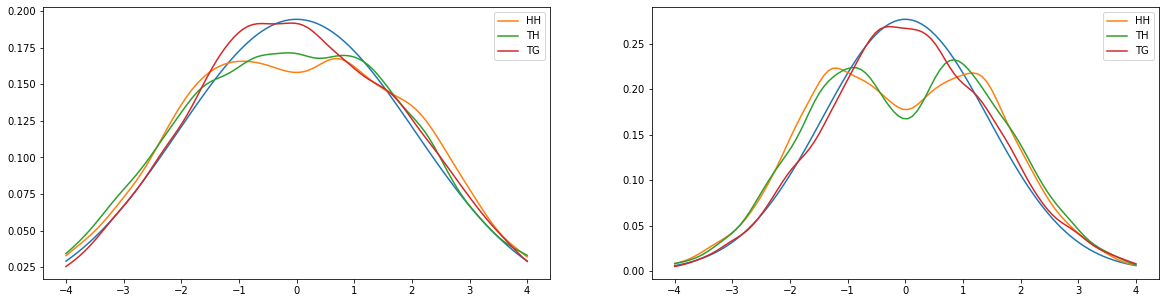

In [132]:
quick_MVN_marginals_kdes([hhsamples, thsamples, tgsamples], target, ['HH', 'TH', 'TG'])

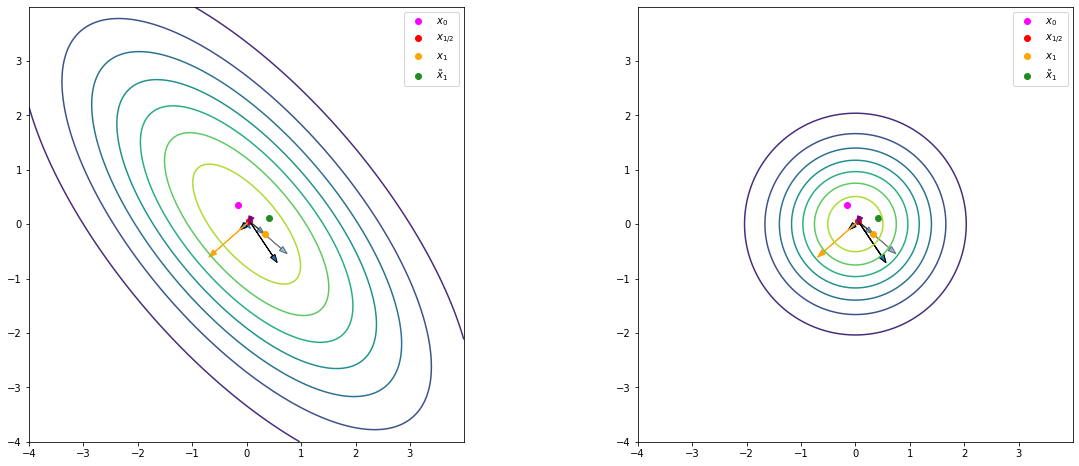

In [169]:
x0 = target.rvs()

A = np.linalg.cholesky(Sigma).T
func = lambda xy: target.pdf(xy @ A) * det(A)
grad_log_pi = lambda xy: -solve(Sigma, xy - mu)

delta = 0.8

v0 = q.rvs()
xmid = x0 + delta*v0/2
g = grad_log_pi(xmid)
gnorm = norm(g)
ghat = g / gnorm
Ag = A @ g
vr = v0 - 2*(v0 @ ghat) * ghat
vrA = v0 - 2*(v0 @ Ag) * Ag / (Ag @ Ag)
xfinal = xmid + delta*vr/2
xfinalA = xmid + delta*vrA/2

# Arrow


fig, ax = plt.subplots(ncols=2, figsize=(20, 8))
ax[0].contour(*prep_contour([-4, 4], [-4, 4], 0.01, target.pdf))
ax[0].scatter(*mu, marker="*", s=100)
ax[0].scatter(*x0, color='magenta', label=r'$x_0$')
ax[0].scatter(*xmid, color='red', label=r'$x_{1/2}$')
ax[0].scatter(*xfinal, color='orange', label=r'$x_1$')
ax[0].scatter(*xfinalA, color='forestgreen', label=r'$\tilde{x}_1$')
ax[0].arrow(*xmid, *(v0), length_includes_head=True, head_width=0.1)
ax[0].arrow(*xmid, *(2 * (v0 @ ghat)*ghat), length_includes_head=True, head_width=0.1)
ax[0].arrow(*xmid, *(ghat), length_includes_head=True, head_width=0.1, color='orange')  # Gradient at midpoint
ax[0].arrow(*xmid, *(v0 - 2*(ghat@v0)*ghat), length_includes_head=True, head_width=0.1, alpha=0.5, zorder=-10)
ax[0].arrow(*xmid, *((v0 - 2*(ghat@v0)*ghat)*delta/2), length_includes_head=True, head_width=0.1, alpha=0.5, zorder=-10)
ax[0].arrow(*xmid, *(Ag), length_includes_head=True, head_width=0.1, color='purple')
ax[0]
ax[0].set_aspect("equal")
ax[0].legend()
ax[1].contour(*prep_contour([-4, 4], [-4, 4], 0.01, func))
ax[1].scatter(*x0, color='magenta', label=r'$x_0$')
ax[1].scatter(*xmid, color='red', label=r'$x_{1/2}$')
ax[1].scatter(*xfinal, color='orange', label=r'$x_1$')
ax[1].scatter(*xfinalA, color='forestgreen', label=r'$\tilde{x}_1$')
ax[1].arrow(*xmid, *(v0), length_includes_head=True, head_width=0.1)
ax[1].arrow(*xmid, *(v0), length_includes_head=True, head_width=0.1)
ax[1].arrow(*xmid, *(2 * (v0 @ ghat)*ghat), length_includes_head=True, head_width=0.1)
ax[1].arrow(*xmid, *(ghat), length_includes_head=True, head_width=0.1, color='orange')  # Gradient at midpoint
ax[1].arrow(*xmid, *(v0 - 2*(ghat@v0)*ghat), length_includes_head=True, head_width=0.1, alpha=0.5, zorder=-10)
ax[1].arrow(*xmid, *((v0 - 2*(ghat@v0)*ghat)*delta/2), length_includes_head=True, head_width=0.1, alpha=0.5, zorder=-10)
ax[1].arrow(*xmid, *(Ag), length_includes_head=True, head_width=0.1, color='purple')
ax[1].set_aspect("equal")
ax[1].legend()

# Behavior of HUG PC

In [140]:
NN = 200
hug_stuff, _ = Hug(x0, T, B, NN, q, logpi, grad_log_pi)
hugpc_stuff, _ = HugPC(x0, T, B, lambda xy: Sigma, NN, q, logpi, grad_log_pi)
thug_stuff, _ = HugTangential(x0, T, B, NN, 0.99, q, logpi, grad_log_pi)

In [141]:
np.unique(thug_stuff, axis=0).shape[0], np.unique(hugpc_stuff, axis=0).shape[0]

(161, 154)

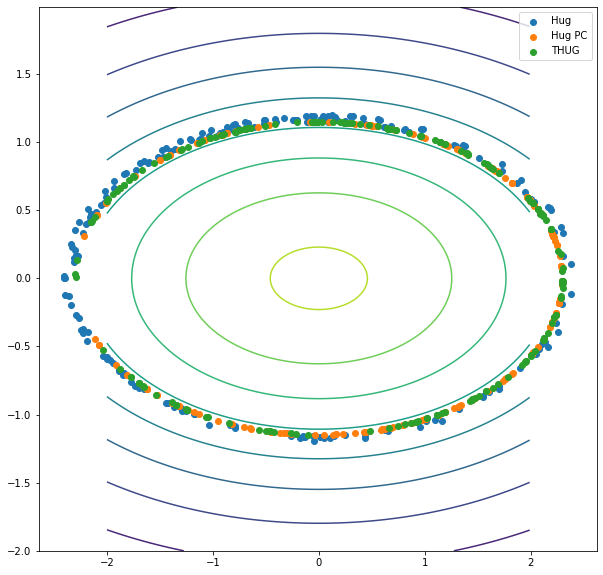

In [142]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.contour(*prep_contour([-2, 2], [-2, 2], 0.01, target.pdf))
ax.scatter(*hug_stuff.T, label='Hug')
ax.scatter(*hugpc_stuff.T, label='Hug PC')
ax.scatter(*thug_stuff.T, label='THUG')
ax.legend()
#ax.set_aspect("equal")
plt.show()

# Behavior of HOP PC

In [143]:
NN = 20000
hop_stuff = x0
hoppc_stuff = x0

stuff = x0
for _ in range(NN):
    stuff, _ = Hop(stuff, lam, k, logpi, grad_log_pi)
    hop_stuff = np.vstack((hop_stuff, stuff))
    
SS = np.cov(hop_stuff.T)
SS_func = lambda xy: SS
stuff = x0

for _ in range(NN):
    stuff, _ = HopPC(stuff, SS_func, lam, k, logpi, grad_log_pi)
    hoppc_stuff = np.vstack((hoppc_stuff, stuff))

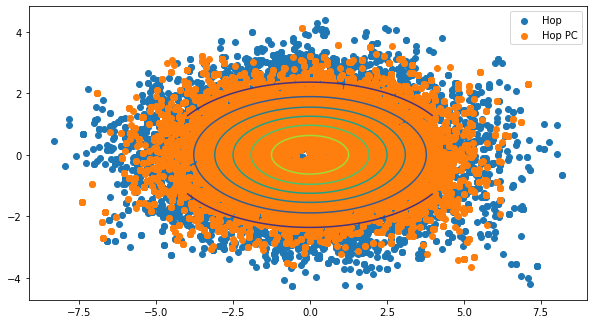

In [144]:
AT = cholesky(Sigma)
detAT = det(AT)
func = lambda xy: target.pdf((AT @ xy.T).T) * detAT
fig, ax = plt.subplots(figsize=(10, 10))
ax.contour(*prep_contour([-4, 4], [-4, 4], 0.01, target.pdf))
ax.scatter(*hop_stuff.T, label='Hop')
ax.scatter(*hoppc_stuff.T, label='Hop PC')
ax.legend()
ax.set_aspect("equal")
plt.show()

# Together

In [145]:
hhpc_stuff, _, _ = run_hug_hop_pc(x0, T, B, lambda xy: Sigma, N, lam, k, q, logpi, grad_log_pi)

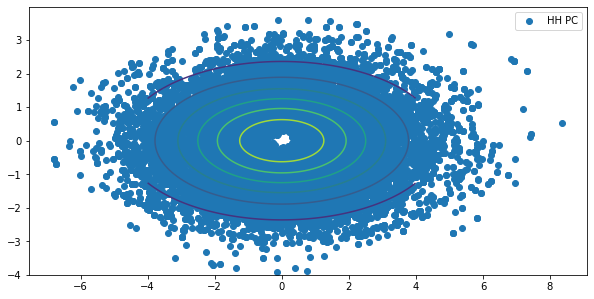

In [147]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.contour(*prep_contour([-4, 4], [-4, 4], 0.01, target.pdf))
ax.scatter(*hhpc_stuff.T, label='HH PC')
ax.legend()
ax.set_aspect("equal")
plt.show()

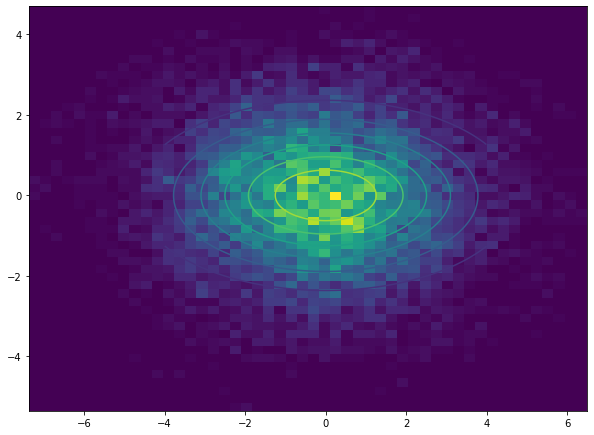

In [153]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.contour(*prep_contour([-4, 4], [-4, 4], 0.01, target.pdf))
ax.hist2d(*hgsamples.T, bins=50)
ax.set_aspect("equal")
plt.show()

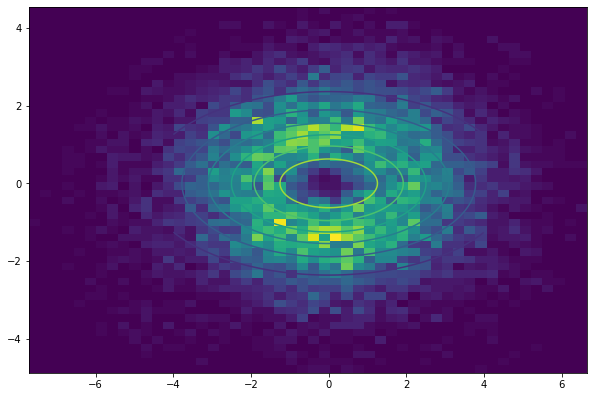

In [154]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.contour(*prep_contour([-4, 4], [-4, 4], 0.01, target.pdf))
ax.hist2d(*hhsamples.T, bins=50)
ax.set_aspect("equal")
plt.show()